# Example of global pipeline using SCDB dataset

Using a yoloV8 model that has been trained to recognize biomarkers on images. 

Link to the SCDB dataset: [https://github.com/adriano-lucieri/SCDB](https://github.com/adriano-lucieri/SCDB)

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from ultralytics import YOLO

from torchvision.io import read_image, ImageReadMode
from torchvision import transforms

from ontoclassifier import *

from PIL import Image
import matplotlib.pyplot as plt

## Loading ontology

In [2]:
onto_filename = "data/scdb.xml"
scdb = owlready2.get_ontology(onto_filename).load()

## Global pipeline with Yolov8 Wrapper

In [3]:
# Selecting targeted classes
target_classes = [scdb.C1, scdb.C2]

# or use all descendants of a class:
# target_classes = list(onto.Lesion.descendants())

In [4]:
# Loading pretrained YoloV8 object model detecting biomarkers
yolo_model = YOLO('data/scdb-yolov8.pt')
yolo_model.names

{0: 'Cross',
 1: 'Ellipse',
 2: 'Hexagon',
 3: 'Line',
 4: 'Pentagon',
 5: 'Rectangle',
 6: 'Star',
 7: 'Starmarker',
 8: 'Triangle',
 9: 'Tripod'}

In [5]:
# Creating Property Wrappers
hasConcept_feature = OntoFeature(scdb.hasConcept) 
hasConcept_property_wrapper = YoloV8PropertyWrapper(yolo_model, 
                                                    hasConcept_feature, 
                                                    yolo_model.names)

In [6]:
# Creating the Ontological Feature Extractor
fe_yolo = Yolov8FeaturesExtractor([ hasConcept_property_wrapper ])
ontological_extractor = OntologicalExtractor([fe_yolo])

In [7]:
# Creating the OntoClassifier instance
onto_classifier = OntoClassifier(scdb, target_classes, ontological_extractor)

In [8]:
# Creating the hybrid AI pipeline
pipeline = torch.nn.Sequential(
        ontological_extractor,
        onto_classifier
)

## Inference

In [9]:
images = ['data/scdb-000000.png', 'data/scdb-000017.png']

YOLO_IMG_SIZE = (640, 640)

img_tensors = []
for img in images:
    img_tensors.append(transforms.Resize(YOLO_IMG_SIZE, antialias=False)(read_image(img, ImageReadMode.RGB).float()))

inputs = torch.stack(img_tensors)

In [10]:
preds = pipeline(inputs).to(torch.uint8)
# Classification results
labels = onto_classifier.getTargettedClassesEncoder().inverse_transform(preds)
pprint(labels)

[('https://www.univ-littoral.fr/lisic/sysreic/scdb.xml#C1',),
 ('https://www.univ-littoral.fr/lisic/sysreic/scdb.xml#C2',)]


In [11]:
# Focusing on a specific image
num = 0

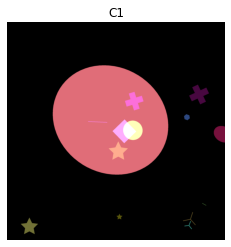

In [12]:
img = Image.open(images[num])

classes = [scdb.search(iri=iri)[0] for iri in labels[num]]
names = [c.name for c in classes]

title = str(names).replace('[', '').replace(']', '').replace('\'', '').replace(',', '\n')
plt.title(title)
plt.axis('off')
plt.imshow(img)

## Explain results

In [13]:
# Instanciating a simple explainer using the OntoClassifier features
explainer = OntologicalExtractorExplainer(ontological_extractor, onto_classifier)

This is a C1 because : 
  This is a C1_b because : 
    hasConcept SOME Ellipse is True 
      found Ellipse
    hasConcept SOME Star is True 
      found Star



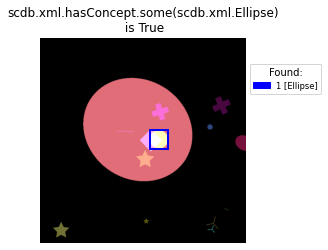

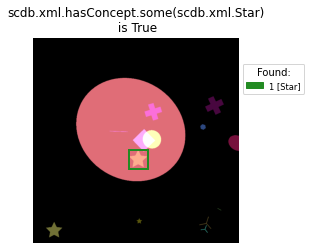

In [14]:
# Explaining why the given image is (NOT ?) classified as a C1
explainer.explain(
    scdb.C1, 
    torch.stack([inputs[0]]))